# Release Strategy Analysis

Analyze release timing, pricing sensitivity, and brand strategy
to generate actionable insights for sneaker release planning.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sneaker_intel.data import load_dataset, DatasetType
from sneaker_intel.analysis.release_strategy import ReleaseStrategyAnalyzer
from sneaker_intel.visualization.style import apply_nike_style

apply_nike_style()

df = load_dataset(DatasetType.MARKET_2023)
analyzer = ReleaseStrategyAnalyzer(df)
print(f'Analyzing {len(df)} products')

Analyzing 2000 products


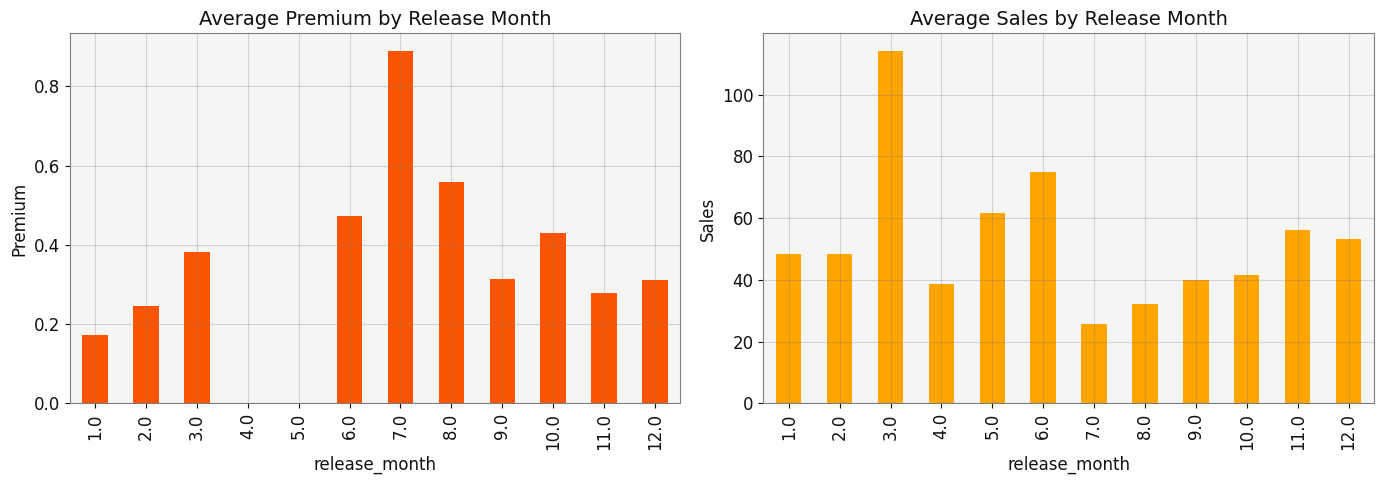

,avg_premium,avg_sales,count
release_month,,,
1.0,0.173,48.417,139
2.0,0.247,48.302,212
3.0,0.382,114.130,254
4.0,inf,38.544,158
5.0,inf,61.721,204
6.0,0.472,75.065,153
7.0,0.889,25.594,106
8.0,0.559,32.191,110
9.0,0.313,40.050,120


In [2]:
# Release timing analysis
timing = analyzer.timing_analysis()
if not timing.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    timing['avg_premium'].plot(kind='bar', ax=axes[0])
    axes[0].set_title('Average Premium by Release Month')
    axes[0].set_ylabel('Premium')
    
    timing['avg_sales'].plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_title('Average Sales by Release Month')
    axes[1].set_ylabel('Sales')
    plt.tight_layout()
    plt.show()

timing

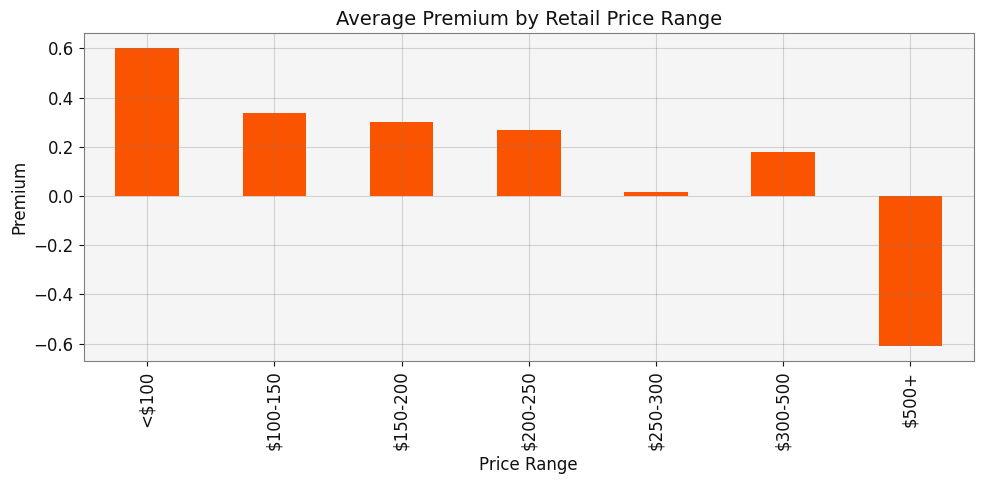

,avg_premium,avg_sales,count
price_bin,,,
<$100,0.601,81.501,455
$100-150,0.338,47.481,837
$150-200,0.301,43.411,491
$200-250,0.267,79.677,186
$250-300,0.018,52.750,12
$300-500,0.181,72.714,7
$500+,-0.610,27.000,2


In [3]:
# Pricing sensitivity
pricing = analyzer.pricing_sensitivity()

fig, ax = plt.subplots(figsize=(10, 5))
pricing['avg_premium'].plot(kind='bar', ax=ax)
ax.set_title('Average Premium by Retail Price Range')
ax.set_ylabel('Premium')
ax.set_xlabel('Price Range')
plt.tight_layout()
plt.show()

pricing

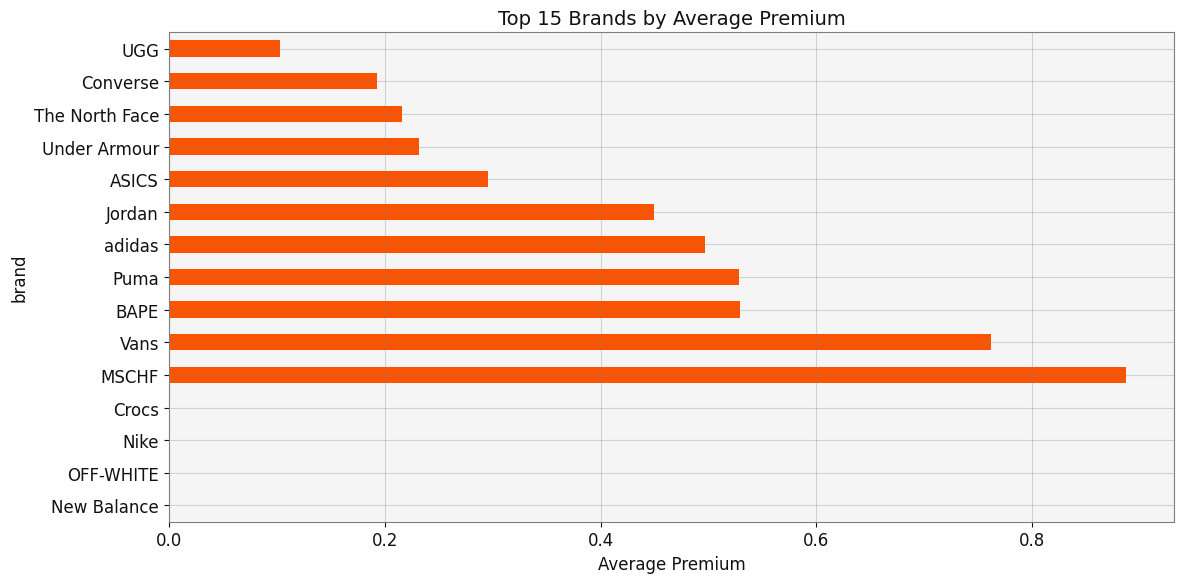

,avg_premium,avg_sales,avg_volatility,count
brand,,,,
New Balance,inf,39.007,0.143,135
OFF-WHITE,inf,18.500,0.057,2
Nike,inf,57.090,0.138,869
Crocs,inf,52.842,0.148,19
MSCHF,0.887,43.500,0.164,2
Vans,0.762,35.000,0.154,1
BAPE,0.529,14.000,0.340,1
Puma,0.528,41.500,0.146,14
adidas,0.497,82.952,0.133,231


In [4]:
# Brand comparison
brands = analyzer.brand_comparison()

top_brands = brands.head(15)
fig, ax = plt.subplots(figsize=(12, 6))
top_brands['avg_premium'].plot(kind='barh', ax=ax)
ax.set_title('Top 15 Brands by Average Premium')
ax.set_xlabel('Average Premium')
plt.tight_layout()
plt.show()

top_brands